In [58]:
# Setup
import os
import glob
import pandas as pd
import numpy as np
from typing import Tuple

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support
from scipy.stats import ks_2samp
from imblearn.over_sampling import RandomOverSampler

RANDOM_STATE = 42
DATA_DIR = os.path.join(os.getcwd(), 'data')

pd.set_option('display.max_columns', None)
print('DATA_DIR:', DATA_DIR)

# Load dataset(s) from /data
def load_first_csv(data_dir: str) -> pd.DataFrame:
    csvs = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
    if not csvs:
        raise FileNotFoundError(f'No CSV files found in {data_dir}')
    print('Using CSV:', csvs[0])
    df = pd.read_csv(csvs[0])
    return df

df_raw = load_first_csv(DATA_DIR)
print('Shape:', df_raw.shape)
df_raw.head()



DATA_DIR: /home/pcgr/Code/churn-predict/data
Using CSV: /home/pcgr/Code/churn-predict/data/customer_churn_telecom_services.csv
Shape: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [59]:
# Definir coluna alvo
target_col = "Churn"

# Normalizar o alvo para binário 0/1
df = df_raw.copy()
def to_binary(series):
    if series.dtype == 'O':
        return series.str.lower().map({'yes':1,'sim':1,'true':1,'y':1,'1':1,'no':0,'nao':0,'false':0,'n':0,'0':0}).fillna(series)
    return series
df[target_col] = to_binary(df[target_col])
if df[target_col].dtype == 'O':
    # Se ainda for objeto, tente astype(int) após mapear os únicos
    uniques = df[target_col].unique()
    print('Warning: target still object. Uniques:', uniques)

# Organiza TotalCharges como float
if df['TotalCharges'].dtype == 'O':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip().replace('', np.nan), errors='coerce')
    print('TotalCharges converted to float. Missing:', df['TotalCharges'].isna().sum())

print('Class balance:', df[target_col].value_counts(dropna=False))
print('Missing per column:\n', df.isna().sum())

Class balance: Churn
0    5174
1    1869
Name: count, dtype: int64
Missing per column:
 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [60]:
# Remove linhas com NaN em TotalCharges
before = len(df)
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
after = len(df)
print(f'Dropped {before - after} rows with NaN TotalCharges. New shape: {df.shape}')
print('Class balance after drop:', df[target_col].value_counts(dropna=False))

Dropped 11 rows with NaN TotalCharges. New shape: (7032, 20)
Class balance after drop: Churn
0    5163
1    1869
Name: count, dtype: int64


In [61]:
# Pré processamento: separar X e y
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

categorical_cols = [c for c in X.columns if X[c].dtype == 'O']
numeric_cols = [c for c in X.columns if c not in categorical_cols]
print('Categorical:', categorical_cols)
print('Numeric:', numeric_cols)

numeric_pipeline = Pipeline(steps=[
    ('impute', 'passthrough'),
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [62]:
import pandas as pd

# Supondo que df já foi carregado e a coluna alvo é 'Churn'
df_class1 = df[df['Churn'] == 0]  # não churn
df_class2 = df[df['Churn'] == 1]  # churn

print("Classe 1 (não churn):", len(df_class1))
print("Classe 2 (churn):", len(df_class2))

total = len(df_class1) + len(df_class2)
print(f"Classe 1: {len(df_class1)} ({len(df_class1)/total:.2%})")
print(f"Classe 2: {len(df_class2)} ({len(df_class2)/total:.2%})")

Classe 1 (não churn): 5163
Classe 2 (churn): 1869
Classe 1: 5163 (73.42%)
Classe 2: 1869 (26.58%)


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Para classe 1 (maioria)
train_c1, temp_c1 = train_test_split(df_class1, test_size=0.5, random_state=42, stratify=None)
val_c1, test_c1 = train_test_split(temp_c1, test_size=0.5, random_state=42)

# Para classe 2 (minoritária)
train_c2, temp_c2 = train_test_split(df_class2, test_size=0.5, random_state=42, stratify=None)
val_c2, test_c2 = train_test_split(temp_c2, test_size=0.5, random_state=42)


# Balancear treino
train_c2_bal = resample(train_c2, replace=True, n_samples=len(train_c1), random_state=42)
val_c2_bal = resample(val_c2, replace=True, n_samples=len(val_c1), random_state=42)

# Teste fica sem repetição

train_df = pd.concat([train_c1, train_c2_bal]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([val_c1, val_c2_bal]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_c1, test_c2]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train, y_train = train_df.drop(columns=['Churn']), train_df['Churn']
X_val, y_val = val_df.drop(columns=['Churn']), val_df['Churn']
X_test, y_test = test_df.drop(columns=['Churn']), test_df['Churn']
print('Train shape:', X_train.shape, 'Class balance:', y_train.value_counts().to_dict())


Train shape: (5162, 19) Class balance: {0: 2581, 1: 2581}


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 1️⃣ Ajusta (fit) apenas com os dados de treinamento
scaler.fit(X_train[numeric_cols])

# 2️⃣ Aplica (transform) a mesma escala em todos os conjuntos
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols]   = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


print("Tamanhos dos conjuntos:")
print("Treinamento:", len(train_df))
print("Validação:", len(val_df))
print("Teste:", len(test_df))

Tamanhos dos conjuntos:
Treinamento: 5162
Validação: 2582
Teste: 1759


In [65]:
print("\nDistribuição das classes:")

print("\nTreino:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

print("\nValidação:")
print(y_val.value_counts())
print(y_val.value_counts(normalize=True))

print("\nTeste:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))



Distribuição das classes:

Treino:
Churn
0    2581
1    2581
Name: count, dtype: int64
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

Validação:
Churn
0    1291
1    1291
Name: count, dtype: int64
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

Teste:
Churn
0    1291
1     468
Name: count, dtype: int64
Churn
0    0.73394
1    0.26606
Name: proportion, dtype: float64


In [66]:
# One-Hot Encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_val   = pd.get_dummies(X_val, drop_first=True)
X_test  = pd.get_dummies(X_test, drop_first=True)

# Alinhar colunas
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

bool_cols = X_train.select_dtypes(include='bool').columns

X_train[bool_cols] = X_train[bool_cols].astype(int)
X_val[bool_cols]   = X_val[bool_cols].astype(int)
X_test[bool_cols]  = X_test[bool_cols].astype(int)

print("Shapes finais:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

print("\nX_Train head()")
X_train.head()

Shapes finais:
X_train: (5162, 30) y_train: (5162,)
X_val  : (2582, 30) y_val  : (2582,)
X_test : (1759, 30) y_test : (1759,)

X_Train head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.486522,1.579406,-1.326839,-0.038879,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,-0.486522,0.119458,0.459904,0.261448,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,-0.486522,-1.006788,-0.754874,-0.856418,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,-0.486522,-0.005681,-0.118973,-0.121568,1,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,2.055407,-0.339383,0.200705,-0.276277,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [67]:
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)

X_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.486522,1.579406,-1.326839,-0.038879,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.486522,0.119458,0.459904,0.261448,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.486522,-1.006788,-0.754874,-0.856418,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.486522,-0.005681,-0.118973,-0.121568,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.055407,-0.339383,0.200705,-0.276277,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# Treinamento da Baseline

In [68]:
import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score


# =========================
# Métricas
# =========================
def ks_score(y_true, p1):
    y_true = np.asarray(y_true).astype(int)
    p1 = np.asarray(p1)

    pos = p1[y_true == 1]
    neg = p1[y_true == 0]
    if pos.size == 0 or neg.size == 0:
        return np.nan

    return ks_2samp(pos, neg).statistic


def safe_roc_auc(y_true, p1):
    y_true = np.asarray(y_true).astype(int)
    p1 = np.asarray(p1)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, p1)


# =========================
# Modelo STab (corrigido)
# =========================
class STabModel(nn.Module):
    def __init__(
        self,
        n_features: int,
        dim: int = 16,
        depth: int = 1,
        heads: int = 2,
        attn_dropout: float = 0.10,  # input dropout
        ff_dropout: float = 0.10,    # dropout interno do encoder layer
        U: int = 64,
        cases: str = "cls"
    ):
        super().__init__()
        assert cases in ("cls", "mean", "sum")
        assert dim % heads == 0, "dim must be divisible by heads"

        self.cases = cases

        self.feature_embed = nn.Parameter(torch.randn(n_features, dim) * 0.02)
        self.feature_bias  = nn.Parameter(torch.zeros(n_features, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim) * 0.02)

        self.input_dropout = nn.Dropout(attn_dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=U,
            dropout=ff_dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Dropout(ff_dropout),
            nn.Linear(dim, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, n_features)
        tokens = x.unsqueeze(-1) * self.feature_embed.unsqueeze(0) + self.feature_bias.unsqueeze(0)

        if self.cases == "cls":
            cls = self.cls_token.expand(x.size(0), -1, -1)  # (B,1,dim)
            tokens = torch.cat([cls, tokens], dim=1)        # (B, 1+n_features, dim)

        tokens = self.input_dropout(tokens)
        h = self.encoder(tokens)

        if self.cases == "cls":
            pooled = h[:, 0, :]
        elif self.cases == "mean":
            pooled = h.mean(dim=1)
        else:  # "sum"
            pooled = h.sum(dim=1)

        logits = self.head(pooled).squeeze(-1)
        return logits


In [69]:


# =========================
# Utils de treino/avaliação
# =========================
def to_tensor(x, dtype=torch.float32):
    if isinstance(x, torch.Tensor):
        return x.to(dtype)
    return torch.tensor(x, dtype=dtype)


@torch.no_grad()
def evaluate(model, loader, device="cuda"):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()

    total_loss = 0.0
    n = 0
    y_all, p_all = [], []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device).float()

        logits = model(xb)
        loss = loss_fn(logits, yb)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        y_np = yb.detach().cpu().numpy()

        y_all.append(y_np)
        p_all.append(probs)

        bs = xb.size(0)
        total_loss += loss.item() * bs
        n += bs

    y_all = np.concatenate(y_all) if y_all else np.array([])
    p_all = np.concatenate(p_all) if p_all else np.array([])

    return {
        "loss": total_loss / max(n, 1),
        "auc": safe_roc_auc(y_all, p_all) if y_all.size else np.nan,
        "ks": ks_score(y_all, p_all) if y_all.size else np.nan,
    }


def train_baseline(
    X_train, y_train, X_val, y_val,
    batch_size=256,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=10_000,
    patience=20,
    ckpt_path="stab_baseline_best.pt",
    device=None,
    seed=42,
):
    # Reprodutibilidade
    torch.manual_seed(seed)
    np.random.seed(seed)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Converte pra tensores float (X) e long/int (y mas vira float no loss)
    X_train_t = to_tensor(X_train, torch.float32)
    y_train_t = to_tensor(y_train, torch.float32)
    X_val_t   = to_tensor(X_val, torch.float32)
    y_val_t   = to_tensor(y_val, torch.float32)

    # Dataloaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    n_features = X_train_t.shape[1]

    # Baseline (pequena)
    model = STabModel(
        n_features=n_features,
        dim=16,
        depth=1,
        heads=2,
        U=64,
        attn_dropout=0.10,
        ff_dropout=0.10,
        cases="cls"
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.BCEWithLogitsLoss()

    best = {
        "epoch": -1,
        "ks": -math.inf,
        "state_dict": None
    }
    bad_epochs = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0.0
        n = 0

        for xb, yb in train_loader:
          xb = xb.to(device)
          yb = yb.to(device).float().view(-1)

          optimizer.zero_grad(set_to_none=True)
          logits = model(xb).view(-1)
          loss = loss_fn(logits, yb)
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # ✅

          optimizer.step()


          bs = xb.size(0)
          total_loss += loss.item() * bs
          n += bs

        train_loss = total_loss / max(n, 1)
        val_metrics = evaluate(model, val_loader, device=device)

        ks = val_metrics["ks"]
        auc = val_metrics["auc"]
        val_loss = val_metrics["loss"]

        improved = (not np.isnan(ks)) and (ks > best["ks"] + 1e-6)
        if improved:
            best["epoch"] = epoch
            best["ks"] = ks
            best["state_dict"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0

            # checkpoint automático
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": best["state_dict"],
                    "best_ks": best["ks"],
                    "config": {
                        "dim": 16, "depth": 1, "heads": 2, "U": 64,
                        "attn_dropout": 0.10, "ff_dropout": 0.10, "cases": "cls",
                        "lr": lr, "weight_decay": weight_decay, "batch_size": batch_size,
                        "patience": patience, "max_epochs": max_epochs,
                    }
                },
                ckpt_path
            )
        else:
            bad_epochs += 1

        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:5d} | train_loss {train_loss:.4f} | "
                f"val_loss {val_loss:.4f} | val_auc {auc:.4f} | val_ks {ks:.4f} | "
                f"best_ks {best['ks']:.4f} (ep {best['epoch']}) | bad {bad_epochs}/{patience}"
            )

        if bad_epochs >= patience:
            print(f"Early stopping! Best KS={best['ks']:.4f} at epoch {best['epoch']}.")
            break

    # Carrega melhor estado antes de retornar
    if best["state_dict"] is not None:
        model.load_state_dict(best["state_dict"])

    return model, best


# =========================
# Exemplo de uso
# =========================
# model, best = train_baseline(X_train, y_train, X_val, y_val)
# print(best)
# # Para inferência:
# # probs = torch.sigmoid(model(torch.tensor(X_test, dtype=torch.float32).to(device))).detach().cpu().numpy()


In [70]:
# Tudo numérico e float
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)

# Alvos 0/1
y_train = y_train.astype(int)
y_val   = y_val.astype(int)
y_test  = y_test.astype(int)


In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert pandas DataFrames/Series to NumPy arrays before passing to train_baseline
# The to_tensor function inside train_baseline expects array-like objects that torch.tensor can handle directly,
# which is not always the case for pandas DataFrames/Series without .values or .to_numpy()
X_train_np = X_train.values
y_train_np = y_train.values
X_val_np = X_val.values
y_val_np = y_val.values

model, best = train_baseline(
    X_train_np, y_train_np,
    X_val_np, y_val_np,
    batch_size=256,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=10_000,
    patience=20,
    ckpt_path="stab_baseline_best.pt",
    device=device,
    seed=42
)

Epoch     1 | train_loss 0.6491 | val_loss 0.5860 | val_auc 0.7885 | val_ks 0.5097 | best_ks 0.5097 (ep 1) | bad 0/20


/home/pcgr/Code/churn-predict/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch    10 | train_loss 0.5251 | val_loss 0.5111 | val_auc 0.8351 | val_ks 0.5221 | best_ks 0.5221 (ep 10) | bad 0/20
Epoch    20 | train_loss 0.5104 | val_loss 0.5060 | val_auc 0.8327 | val_ks 0.5167 | best_ks 0.5229 (ep 17) | bad 3/20
Epoch    30 | train_loss 0.5048 | val_loss 0.4935 | val_auc 0.8400 | val_ks 0.5236 | best_ks 0.5314 (ep 25) | bad 5/20
Epoch    40 | train_loss 0.4998 | val_loss 0.5120 | val_auc 0.8340 | val_ks 0.5143 | best_ks 0.5314 (ep 25) | bad 15/20
Early stopping! Best KS=0.5314 at epoch 25.


In [72]:
@torch.no_grad()
def predict_proba(model, X, device="cuda"):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    return probs


In [73]:
p_test = predict_proba(model, X_test.values, device=device)
y_test_np = y_test.values


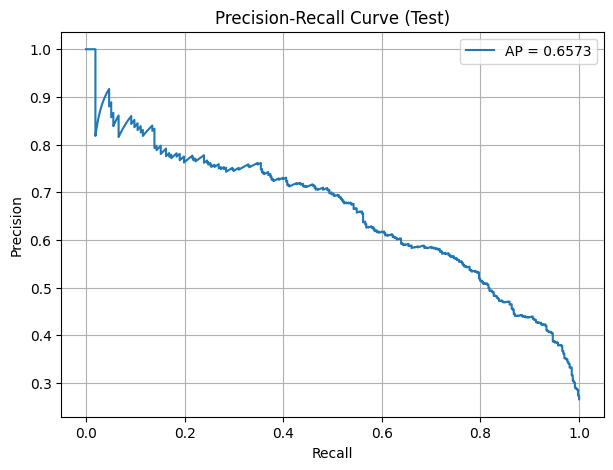

In [74]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test_np, p_test)
ap = average_precision_score(y_test_np, p_test)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.grid(True)
plt.show()


In [75]:
def plot_ks(y_true, p):
    df_ks = pd.DataFrame({
        "y": y_true,
        "p": p
    }).sort_values("p")

    df_ks["cdf_pos"] = (df_ks["y"] == 1).cumsum() / (df_ks["y"] == 1).sum()
    df_ks["cdf_neg"] = (df_ks["y"] == 0).cumsum() / (df_ks["y"] == 0).sum()

    ks = np.max(np.abs(df_ks["cdf_pos"] - df_ks["cdf_neg"]))

    plt.figure(figsize=(7,5))
    plt.plot(df_ks["p"], df_ks["cdf_pos"], label="CDF Churn (1)")
    plt.plot(df_ks["p"], df_ks["cdf_neg"], label="CDF Não Churn (0)")
    plt.title(f"KS Curve (Test) — KS = {ks:.4f}")
    plt.xlabel("Probabilidade prevista")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

    return ks


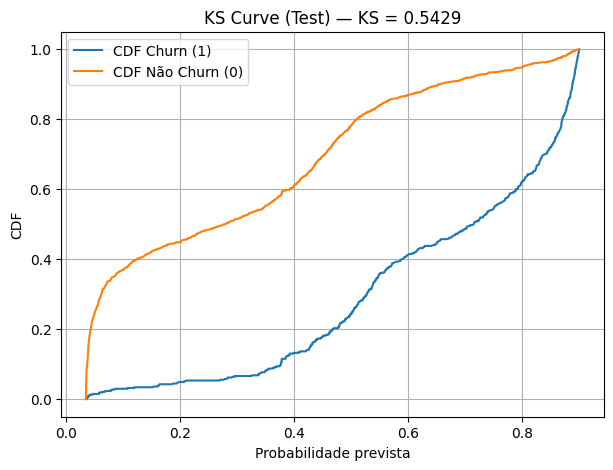

KS no teste: 0.5429419319814361


In [76]:
ks_test = plot_ks(y_test_np, p_test)
print("KS no teste:", ks_test)


In [77]:
import pandas as pd
import numpy as np

df_ks = pd.DataFrame({
    "y": y_test_np,
    "p": p_test
}).sort_values("p")

df_ks["cdf_pos"] = (df_ks["y"] == 1).cumsum() / (df_ks["y"] == 1).sum()
df_ks["cdf_neg"] = (df_ks["y"] == 0).cumsum() / (df_ks["y"] == 0).sum()
df_ks["diff"] = np.abs(df_ks["cdf_pos"] - df_ks["cdf_neg"])

best_threshold = df_ks.loc[df_ks["diff"].idxmax(), "p"]
best_threshold


np.float32(0.4764786)

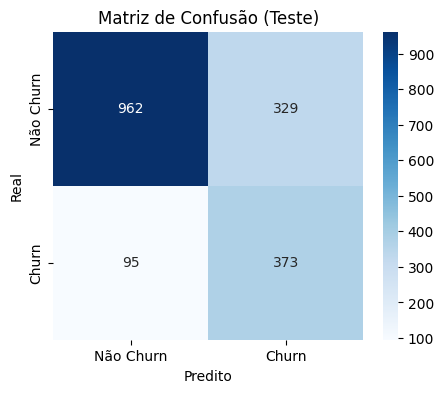

In [78]:
y_pred = (p_test >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Não Churn", "Churn"],
    yticklabels=["Não Churn", "Churn"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Teste)")
plt.show()

In [79]:
from sklearn.metrics import precision_recall_fscore_support

p, r, f1, _ = precision_recall_fscore_support(
    y_test_np, y_pred, average=None
)

print(f"Churn → Precision: {p[1]:.3f}, Recall: {r[1]:.3f}, F1: {f1[1]:.3f}")


Churn → Precision: 0.531, Recall: 0.797, F1: 0.638


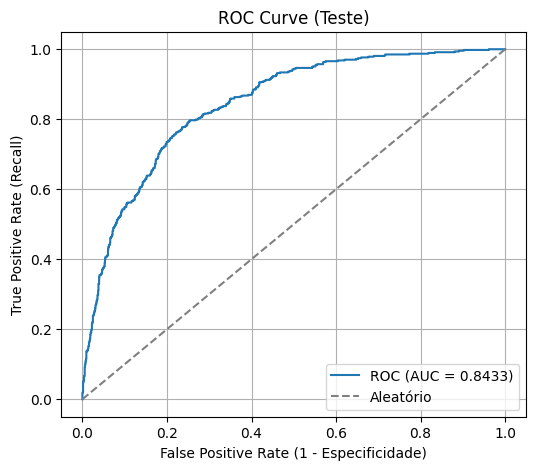

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# y_test_np e p_test você já tem
fpr, tpr, thresholds = roc_curve(y_test_np, p_test)
auc = roc_auc_score(y_test_np, p_test)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Aleatório")
plt.xlabel("False Positive Rate (1 - Especificidade)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Teste)")
plt.legend()
plt.grid(True)
plt.show()


In [81]:
import numpy as np

def subsample_train(X, y, n, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=min(n, len(X)), replace=False)
    return X[idx], y[idx]


In [82]:
import optuna
import math
import torch
import numpy as np

def train_with_params(
    X_train_np, y_train_np, X_val_np, y_val_np,
    dim, depth, heads, U, attn_dropout, ff_dropout, cases,
    lr, weight_decay, batch_size,
    max_epochs=3000, patience=30,
    seed=42,
    device=None,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # tensores
    X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_np, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val_np, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val_np, dtype=torch.float32)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_t, y_train_t),
        batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val_t, y_val_t),
        batch_size=batch_size, shuffle=False
    )

    n_features = X_train_t.shape[1]

    model = STabModel(
        n_features=n_features,
        dim=dim,
        depth=depth,
        heads=heads,
        U=U,
        attn_dropout=attn_dropout,
        ff_dropout=ff_dropout,
        cases=cases
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    best_ks = -math.inf
    bad = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).float().view(-1)

            opt.zero_grad(set_to_none=True)
            logits = model(xb).view(-1)
            loss = loss_fn(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        val_metrics = evaluate(model, val_loader, device=device)
        ks = val_metrics["ks"]

        if not np.isnan(ks) and ks > best_ks + 1e-6:
            best_ks = ks
            bad = 0
        else:
            bad += 1

        if bad >= patience:
            break

    return best_ks


/home/pcgr/Code/churn-predict/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
def objective(trial):
    # --- Espaço de busca (ajuste se quiser) ---
    dim = trial.suggest_categorical("dim", [8, 16, 32, 64])
    depth = trial.suggest_int("depth", 1, 4)
    heads = trial.suggest_categorical("heads", [1, 2, 4, 8])
    U = trial.suggest_int("U", 32, 256, step=32)

    attn_dropout = trial.suggest_float("attn_dropout", 0.0, 0.3)
    ff_dropout   = trial.suggest_float("ff_dropout", 0.0, 0.3)
    cases = trial.suggest_categorical("cases", ["cls", "mean", "sum"])

    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])
    sample_size = trial.suggest_categorical("sample_size", [1024, 2048, 4096, 8192, "all"])

    # heads precisa dividir dim
    if dim % heads != 0:
        raise optuna.exceptions.TrialPruned()

    # subamostra (opcional)
    Xtr, ytr = X_train_np, y_train_np
    if sample_size != "all":
        Xtr, ytr = subsample_train(X_train_np, y_train_np, n=sample_size, seed=42 + trial.number)

    ks = train_with_params(
        Xtr, ytr, X_val_np, y_val_np,
        dim=dim, depth=depth, heads=heads, U=U,
        attn_dropout=attn_dropout, ff_dropout=ff_dropout, cases=cases,
        lr=lr, weight_decay=weight_decay, batch_size=batch_size,
        max_epochs=2500, patience=25,
        seed=42,
        device=device,
    )

    return ks  # Optuna vai maximizar


In [84]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)  # aumente para 80/120 se quiser

print("Melhor KS (val):", study.best_value)
print("Melhores params:", study.best_params)


[I 2025-12-18 18:41:21,985] A new study created in memory with name: no-name-ceffb7bc-3b99-47c2-89fd-388b865c2663
/home/pcgr/Code/churn-predict/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:41:24,110] Trial 0 finished with value: 0.5367931835786213 and parameters: {'dim': 8, 'depth': 4, 'heads': 8, 'U': 192, 'attn_dropout': 0.03440908459646047, 'ff_dropout': 0.1633101252515515, 'cases': 'sum', 'lr': 0.0004778539665500568, 'weight_decay': 0.003457020019710108, 'batch_size': 512, 'sample_size': 'all'}. Best is trial 0 with value: 0.5367931835786213.
/home/pcgr/Code/churn-predict/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
[I 2025-12-18 18:41:28,47

Melhor KS (val): 0.5546088303640588
Melhores params: {'dim': 32, 'depth': 4, 'heads': 2, 'U': 128, 'attn_dropout': 0.10546360047114847, 'ff_dropout': 0.06256732931459441, 'cases': 'cls', 'lr': 0.0007067331350624993, 'weight_decay': 0.00018327603960204217, 'batch_size': 512, 'sample_size': 8192}


In [85]:
# ============
# Best params
# ============
best_params = {
    "dim": 64,
    "depth": 4,
    "heads": 2,
    "U": 192,
    "attn_dropout": 0.020975044585001178,
    "ff_dropout": 0.14690268704809023,
    "cases": "mean",
    "lr": 0.00047036999554739116,
    "weight_decay": 0.0017387060254100187,
    "batch_size": 512,
}

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math

device = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# Sem subamostragem: usa tudo
# =========================
Xtr_final, ytr_final = X_train, y_train
Xval_final, yval_final = X_val, y_val

Xtr_t  = torch.tensor(Xtr_final.values, dtype=torch.float32)
ytr_t  = torch.tensor(ytr_final.values, dtype=torch.float32)
Xval_t = torch.tensor(Xval_final.values, dtype=torch.float32)
yval_t = torch.tensor(yval_final.values, dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(Xtr_t, ytr_t),
    batch_size=best_params["batch_size"],
    shuffle=True,
    drop_last=False
)
val_loader = DataLoader(
    TensorDataset(Xval_t, yval_t),
    batch_size=best_params["batch_size"],
    shuffle=False,
    drop_last=False
)

# =========================
# Modelo final
# =========================
model_final = STabModel(
    n_features=Xtr_t.shape[1],
    dim=best_params["dim"],
    depth=best_params["depth"],
    heads=best_params["heads"],
    U=best_params["U"],
    attn_dropout=best_params["attn_dropout"],
    ff_dropout=best_params["ff_dropout"],
    cases=best_params["cases"],
).to(device)

optimizer = torch.optim.AdamW(
    model_final.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)
loss_fn = nn.BCEWithLogitsLoss()

# =========================
# Treino com early stopping por KS
# =========================
max_epochs = 5000
patience = 30
ckpt_path = "stab_final_best_fulltrain.pt"

best = {"ks": -math.inf, "epoch": -1, "state_dict": None}
bad_epochs = 0

for epoch in range(1, max_epochs + 1):
    model_final.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).float().view(-1)

        optimizer.zero_grad(set_to_none=True)
        logits = model_final(xb).view(-1)
        loss = loss_fn(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_final.parameters(), 1.0)
        optimizer.step()

    val_metrics = evaluate(model_final, val_loader, device=device)
    ks = val_metrics["ks"]
    auc = val_metrics["auc"]
    val_loss = val_metrics["loss"]

    improved = (not np.isnan(ks)) and (ks > best["ks"] + 1e-6)
    if improved:
        best["ks"] = ks
        best["epoch"] = epoch
        best["state_dict"] = {k: v.detach().cpu().clone() for k, v in model_final.state_dict().items()}
        bad_epochs = 0

        torch.save(
            {
                "epoch": epoch,
                "best_ks": ks,
                "model_state_dict": best["state_dict"],
                "params": best_params,
            },
            ckpt_path
        )
    else:
        bad_epochs += 1

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:4d} | train_loss {loss.item():.4f} | "
            f"val_loss {val_loss:.4f} | val_auc {auc:.4f} | val_ks {ks:.4f} | "
            f"best_ks {best['ks']:.4f} (ep {best['epoch']}) | bad {bad_epochs}/{patience}"
        )

    if bad_epochs >= patience:
        print(f"Early stopping! Best KS={best['ks']:.4f} at epoch {best['epoch']}.")
        break

# Carrega o melhor estado
if best["state_dict"] is not None:
    model_final.load_state_dict(best["state_dict"])

print("Final best:", best)


/home/pcgr/Code/churn-predict/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch    1 | train_loss 0.4884 | val_loss 0.5533 | val_auc 0.7952 | val_ks 0.5012 | best_ks 0.5012 (ep 1) | bad 0/30
Epoch   10 | train_loss 0.5821 | val_loss 0.4967 | val_auc 0.8365 | val_ks 0.5345 | best_ks 0.5345 (ep 9) | bad 1/30
Epoch   20 | train_loss 0.5904 | val_loss 0.5228 | val_auc 0.8278 | val_ks 0.5244 | best_ks 0.5345 (ep 9) | bad 11/30
Epoch   30 | train_loss 0.4742 | val_loss 0.5876 | val_auc 0.8090 | val_ks 0.4725 | best_ks 0.5345 (ep 9) | bad 21/30
Early stopping! Best KS=0.5345 at epoch 9.
Final best: {'ks': np.float64(0.5344694035631293), 'epoch': 9, 'state_dict': {'feature_embed': tensor([[-0.0039,  0.0295, -0.0173,  ...,  0.0259,  0.0211,  0.0153],
        [ 0.0006,  0.0036, -0.0154,  ..., -0.0048, -0.0249, -0.0059],
        [-0.0426, -0.0142,  0.0188,  ..., -0.0248, -0.0188,  0.0044],
        ...,
        [ 0.0008,  0.0537, -0.0270,  ..., -0.0406, -0.0068,  0.0144],
        [ 0.0063, -0.0073,  0.0120,  ..., -0.0202, -0.0145, -0.0051],
        [-0.0122, -0.0450,  0

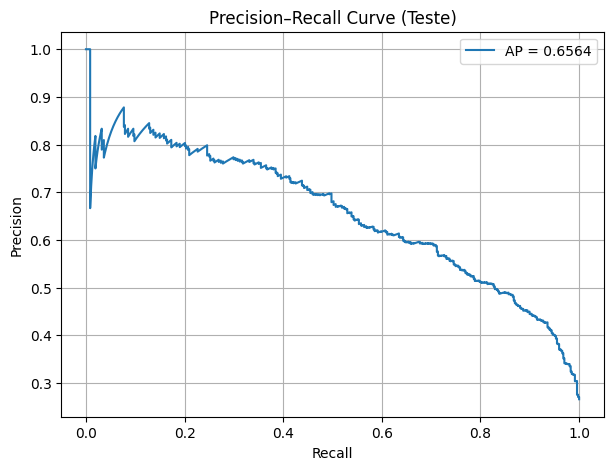

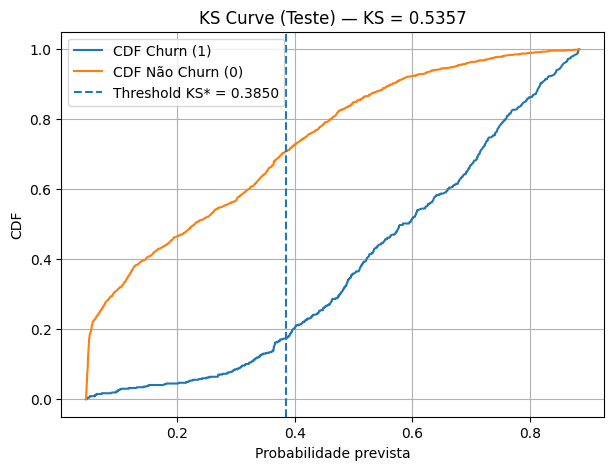

KS no teste: 0.5356759816480963
Melhor threshold (KS máximo): 0.38501382


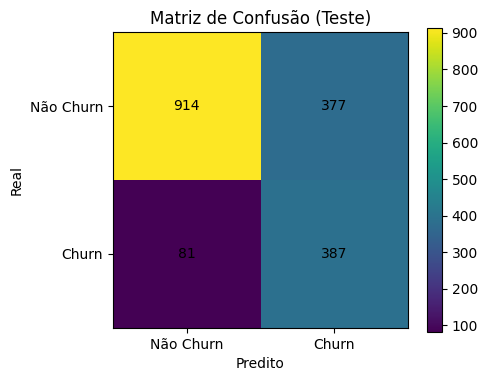

Churn (1) → Precision: 0.507, Recall: 0.827, F1: 0.628


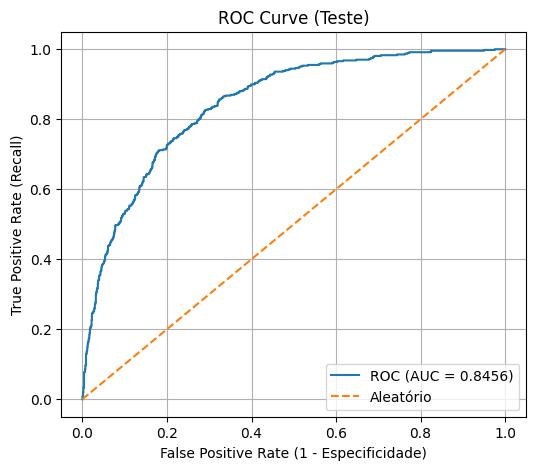

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score,
    confusion_matrix,
    precision_recall_fscore_support
)

# Se você não tiver essa função no notebook, use esta:
@torch.no_grad()
def predict_proba(model, X, device="cuda"):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    return probs

# =========================
# 1) Probabilidades no teste
# =========================
y_test_np = y_test.values if hasattr(y_test, "values") else np.asarray(y_test)
X_test_np = X_test.values if hasattr(X_test, "values") else np.asarray(X_test)

p_test = predict_proba(model_final, X_test_np, device=device).reshape(-1)

# =========================
# 2) Precision–Recall Curve
# =========================
precision, recall, thresholds_pr = precision_recall_curve(y_test_np, p_test)
ap = average_precision_score(y_test_np, p_test)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Teste)")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# 3) KS Curve + KS value
# =========================
def plot_ks(y_true, p):
    df_ks = pd.DataFrame({"y": y_true.astype(int), "p": p}).sort_values("p")

    # CDFs
    pos_total = (df_ks["y"] == 1).sum()
    neg_total = (df_ks["y"] == 0).sum()

    df_ks["cdf_pos"] = (df_ks["y"] == 1).cumsum() / max(pos_total, 1)
    df_ks["cdf_neg"] = (df_ks["y"] == 0).cumsum() / max(neg_total, 1)

    df_ks["diff"] = np.abs(df_ks["cdf_pos"] - df_ks["cdf_neg"])
    ks = df_ks["diff"].max()
    best_threshold = df_ks.loc[df_ks["diff"].idxmax(), "p"]

    plt.figure(figsize=(7, 5))
    plt.plot(df_ks["p"], df_ks["cdf_pos"], label="CDF Churn (1)")
    plt.plot(df_ks["p"], df_ks["cdf_neg"], label="CDF Não Churn (0)")
    plt.axvline(best_threshold, linestyle="--", label=f"Threshold KS* = {best_threshold:.4f}")
    plt.title(f"KS Curve (Teste) — KS = {ks:.4f}")
    plt.xlabel("Probabilidade prevista")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.show()

    return ks, best_threshold

ks_test, best_threshold = plot_ks(y_test_np, p_test)
print("KS no teste:", ks_test)
print("Melhor threshold (KS máximo):", best_threshold)

# =========================
# 4) Matriz de Confusão
# =========================
y_pred = (p_test >= best_threshold).astype(int)
cm = confusion_matrix(y_test_np, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusão (Teste)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Não Churn", "Churn"], rotation=0)
plt.yticks(tick_marks, ["Não Churn", "Churn"])

# números em cada célula
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

p, r, f1, _ = precision_recall_fscore_support(y_test_np, y_pred, average=None)
print(f"Churn (1) → Precision: {p[1]:.3f}, Recall: {r[1]:.3f}, F1: {f1[1]:.3f}")

# =========================
# 5) ROC Curve
# =========================
fpr, tpr, thresholds_roc = roc_curve(y_test_np, p_test)
auc = roc_auc_score(y_test_np, p_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Aleatório")
plt.xlabel("False Positive Rate (1 - Especificidade)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Teste)")
plt.legend()
plt.grid(True)
plt.show()
